In [240]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

In [241]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [242]:
from langchain_core.tools import tool

In [243]:
from langchain_tavily import TavilySearch

In [244]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

In [245]:
multiply.invoke({"a":2, "b": 4})

8

In [246]:
@tool
def search(query: str):
    """Search the web for a query."""
    tavily = TavilySearch()
    result = tavily.invoke(query)
    return result

In [247]:
tools = [search, multiply]

In [248]:
llm_with_tools = llm.bind_tools(tools)

In [249]:
result = llm_with_tools.invoke("What is the current gdp of india?")

In [250]:
result.content

''

In [251]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'India GDP 2025 current GDP 2025 India nominal GDP 2025'},
  'id': 'fc_5a330adb-10e0-4dca-b7a2-4f19ef4654fd',
  'type': 'tool_call'}]

In [252]:
result.tool_calls[0]

{'name': 'search',
 'args': {'query': 'India GDP 2025 current GDP 2025 India nominal GDP 2025'},
 'id': 'fc_5a330adb-10e0-4dca-b7a2-4f19ef4654fd',
 'type': 'tool_call'}

In [253]:
result.tool_calls[0]["name"]

'search'

In [254]:
result.tool_calls[0]["args"]

{'query': 'India GDP 2025 current GDP 2025 India nominal GDP 2025'}

In [255]:
tool_mapping = {tool.name:tool for tool in tools}

In [256]:
tool_mapping

{'search': StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E08A0C0>),
 'multiply': StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E08B060>)}

In [257]:
tool_mapping["search"]

StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E08A0C0>)

In [258]:
tool_mapping["multiply"].invoke({"a":2, "b":3})

6

In [259]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

{'query': 'India GDP 2025 current GDP 2025 India nominal GDP 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.worldometers.info/gdp/india-gdp/',
   'title': 'India GDP (2025)',
   'content': 'Nominal (current) Gross Domestic Product (GDP) of India is $4.13 trillion ($4,125,213,000,000) as of 2025, according to the International Monetary Fund (IMF).',
   'score': 0.99998665,
   'raw_content': None},
  {'url': 'https://www.pib.gov.in/PressReleasePage.aspx?PRID=2221389&reg=3&lang=1',
   'title': "india's real gdp estimated to grow by 7.4% in fy 2025",
   'content': "INDIA'S REAL GDP ESTIMATED TO GROW BY 7.4% IN FY 2025–26, WITH NOMINAL GDP GROWTH AT 8%. IN THE BUDGET FOR FY 2026-27, NOMINAL GDP IS",
   'score': 0.99990237,
   'raw_content': None},
  {'url': 'https://www.isas.nus.edu.sg/papers/measuring-indias-economic-growth-evidence-beyond-the-headline-gdp/',
   'title': "Measuring India's Economic Growth: Evidence Beyond ...",
   'co

In [260]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

In [261]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [262]:
# state = {"messages":["hi","how are you?"]}

In [263]:
def invoke_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [264]:
def router(state: AgentState):
    tool_call = state["messages"][-1].tool_calls
    if tool_call:
        return "tool"
    return "end"

In [265]:
def invoke_tool(state: AgentState):
    tool_details = state["messages"][-1].tool_calls
    if not tool_details:
        raise ValueError("No tool call found")
    print(f"Selected tool: {tool_details[0]['name']}")
    response = tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])

    response = ToolMessage(tool_call_id=tool_details[0]["id"], content=str(response), name=tool_details[0]["name"])
    return {"messages": [response]}


In [266]:
tools

[StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E08A0C0>),
 StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E08B060>)]

In [267]:
from langgraph.graph import StateGraph, START, END

In [268]:
graph = StateGraph(AgentState)

#### earlier we are using the tool node from the list of tool
#### but now we have create tool invoke(cusotm function)
#### as a user if we want to take a authority to which tool I need to give permission for execution

In [269]:
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

In [270]:
graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool": "tool",
        "end": END,
    }
)

In [271]:
graph.add_edge(START, "ai_assistant")

In [272]:
graph.add_edge("tool", END)

In [273]:
memory = MemorySaver()
app = graph.compile(checkpointer=memory, interrupt_before=["tool"])

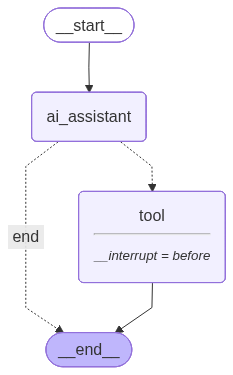

In [274]:
app

In [275]:
config = {"configurable": {"thread_id": "1"}}
app.invoke({"messages":[("user", "what is the current GDP of India?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='2379d6cb-33cf-4852-a701-54e224855b90'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the current GDP of India?" Need up-to-date figure. As of 2026 Feb? We need to browse. Use search tool.', 'tool_calls': [{'id': 'fc_91b81637-4356-49fd-8cc5-8d32cca82ccc', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 2026"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 150, 'total_tokens': 224, 'completion_time': 0.156433818, 'completion_tokens_details': {'reasoning_tokens': 36}, 'prompt_time': 0.005918018, 'prompt_tokens_details': None, 'queue_time': 0.046314592, 'total_time': 0.162351836}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'mo

In [276]:
app.invoke({"messages":[("user", "what is the 40 * 5?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='2379d6cb-33cf-4852-a701-54e224855b90'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the current GDP of India?" Need up-to-date figure. As of 2026 Feb? We need to browse. Use search tool.', 'tool_calls': [{'id': 'fc_91b81637-4356-49fd-8cc5-8d32cca82ccc', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 2026"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 150, 'total_tokens': 224, 'completion_time': 0.156433818, 'completion_tokens_details': {'reasoning_tokens': 36}, 'prompt_time': 0.005918018, 'prompt_tokens_details': None, 'queue_time': 0.046314592, 'total_time': 0.162351836}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'mo

In [277]:
app.invoke({"messages":[("user", "what is the weather in delhi?")]}, config=config)

{'messages': [HumanMessage(content='what is the current GDP of India?', additional_kwargs={}, response_metadata={}, id='2379d6cb-33cf-4852-a701-54e224855b90'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the current GDP of India?" Need up-to-date figure. As of 2026 Feb? We need to browse. Use search tool.', 'tool_calls': [{'id': 'fc_91b81637-4356-49fd-8cc5-8d32cca82ccc', 'function': {'arguments': '{"query":"India GDP 2025 current GDP 2025 2026"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 150, 'total_tokens': 224, 'completion_time': 0.156433818, 'completion_tokens_details': {'reasoning_tokens': 36}, 'prompt_time': 0.005918018, 'prompt_tokens_details': None, 'queue_time': 0.046314592, 'total_time': 0.162351836}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'mo

## langgraph inbuilt human in loop


In [278]:
tools

[StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002243E08A0C0>),
 StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002243E08B060>)]

In [279]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [280]:
llm_with_tools = llm.bind_tools(tools)

In [281]:
def ai_assistant(state: AgentState):
    llm_response = llm_with_tools.invoke(state["messages"])
    return {"messages": [llm_response]}

In [282]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [283]:
from langgraph.prebuilt import ToolNode, tools_condition

In [284]:
tool_node = ToolNode(tools)

In [285]:
graph = StateGraph(AgentState)

In [286]:
graph.add_node("ai_assistant", ai_assistant)

In [287]:
graph.add_node("tools", tool_node)

In [288]:
graph.add_edge(START, "ai_assistant")


In [289]:
graph.add_conditional_edges(
    "ai_assistant", 
    tools_condition,
    )

In [290]:
graph.add_edge("tools", "ai_assistant")

In [291]:
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

### It is going to interrupt before the tool call

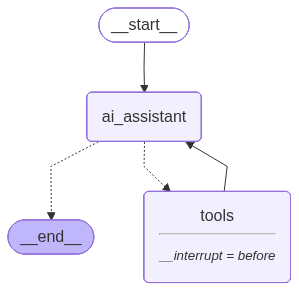

In [292]:
app

In [ ]:
snapshot = app.get_state(config)
if snapshot.next:
    app.invoke(None, config) 

In [ ]:
thread_config = {"configurable": {"thread_id": "1"}}
initial_input = {"messages": [("user", "What is the GDP of India?")]}

# First run - stops before tool
print("--- Starting Graph ---")
for event in app.stream(initial_input, thread_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("\n--- Graph Paused (Interrupt) ---")
print("Reviewing state...")
snapshot = app.get_state(thread_config) 
if snapshot.next:
    print(f"Next step: {snapshot.next}")



--- Starting Graph ---
================================ Human Message =================================

What is the GDP of India?
================================== Ai Message ==================================
Tool Calls:
  search (fc_5b98f89e-e1c8-4366-a23b-5068661bbd94)
 Call ID: fc_5b98f89e-e1c8-4366-a23b-5068661bbd94
  Args:
    query: India GDP 2023 nominal USD
    recency_days: 365
    top_n: 5

--- Graph Paused (Interrupt) ---
Reviewing state...
Next step: ('tools',)


In [300]:
# Resume graph
print("\n--- Resuming Graph ---")
for event in app.stream(None, thread_config, stream_mode="values"):
    event["messages"][-1].pretty_print()


--- Resuming Graph ---
================================== Ai Message ==================================
Tool Calls:
  search (fc_5b98f89e-e1c8-4366-a23b-5068661bbd94)
 Call ID: fc_5b98f89e-e1c8-4366-a23b-5068661bbd94
  Args:
    query: India GDP 2023 nominal USD
    recency_days: 365
    top_n: 5
================================= Tool Message =================================
Name: search

{"query": "India GDP 2023 nominal USD", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://dac0fc.8540.data.globus.org/valid-pics/indias-nominal-gdp-2023-a-usd-snapshot-1764802048", "title": "India's Nominal GDP 2023: A USD Snapshot - Globus", "content": "Estimates place India's nominal GDP in the ballpark of USD 3.7 trillion. Yeah, you read that right – trillion with a 'T'! This figure positions", "score": 0.93762916, "raw_content": null}, {"url": "https://www.spglobal.com/marketintelligence/en/mi/research-analysis/indias-gdp-growth-remains-buoyant-in-2023-sep23